**Introduction:** 

On April 14th, 1912, the Titanic, which was the most advanced ship at the time, hit an iceberg and sank (History.com). Though there were 16 lifeboats that could hold a maximum of 1178 people, out of the 2208 passengers on board, only 705 survived (Barrratt 2009). There were three classes and three different resulting fare values for First, Second, and Third class. Third class made up the majority of the passengers with 709 people, but when the Titanic sank, three-quarters of them died in comparison to those in First and Second Class (Person 2011). Therefore our question is given the age, and fare value of the passenger, can we determine if they would have survived or not? The dataset we will be using is a tabular data set with comma-separated variables. It has 10 variables but out of the 10 we will be using three; Survived, Age, and Fare, in order to answer our question.

**Preliminary exploratory data analysis:**

In [5]:
library(tidyverse)
library(repr)
library(tidymodels)
library(forcats)
library(broom)
options(repr.matrix.max.rows = 6)
train <- read_csv("train.csv") %>% mutate(Survived = as_factor(Survived)) %>%  drop_na(-Cabin)
summary(train)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

  PassengerId    Survived     Pclass         Name               Sex           
 Min.   :  1.0   0:424    Min.   :1.00   Length:712         Length:712        
 1st Qu.:222.8   1:288    1st Qu.:1.00   Class :character   Class :character  
 Median :445.0            Median :2.00   Mode  :character   Mode  :character  
 Mean   :448.6            Mean   :2.24                                        
 3rd Qu.:677.2            3rd Qu.:3.00                                        
 Max.   :891.0            Max.   :3.00                                        
      Age            SibSp           Parch           Ticket         
 Min.   : 0.42   Min.   :0.000   Min.   :0.0000   Length:712        
 1st Qu.:20.00   1st Qu.:0.000   1st Qu.:0.0000   Class :character  
 Median :28.00   Median :0.000   Median :0.0000   Mode  :character  
 Mean   :29.64   Mean   :0.514   Mean   :0.4326                     
 3rd Qu.:38.00   3rd Qu.:1.000   3rd Qu.:1.0000                     
 Max.   :80.00   Max.   :5.000   

The dataset uses the following columns:
<ul>
    <li><em>"PassengerId"</em>: Unique identifier for passengers</li>
    <li><em>"Survived"</em>: Class we are trying to predict, 1=Survived, 2=Passed</li>
    <li><em>"Sex"</em>: Male or Female</li>
    <li><em>"Age"</em>: Age in years(Predictor 1)</li>
    <li><em>"SibSp"</em>: Number of siblings / spouses aboard</li>
    <li><em>"Parch"</em>: Number of parents / children aboard</li>
    <li><em>"Ticket"</em>: Ticket number</li>
    <li><em>"Fare"</em>: Passenger fare (Predictor 2)</li>
    <li><em>"Cabin"</em>: Cabin number</li>
    <li><em>"Embarked"</em>: Port of Embarkation(C = Cherbourg, Q = Queenstown, S = Southampton)</li>
    <li><em>"DirectRelatives"</em>: SibSp + Parch</li>
</ul>

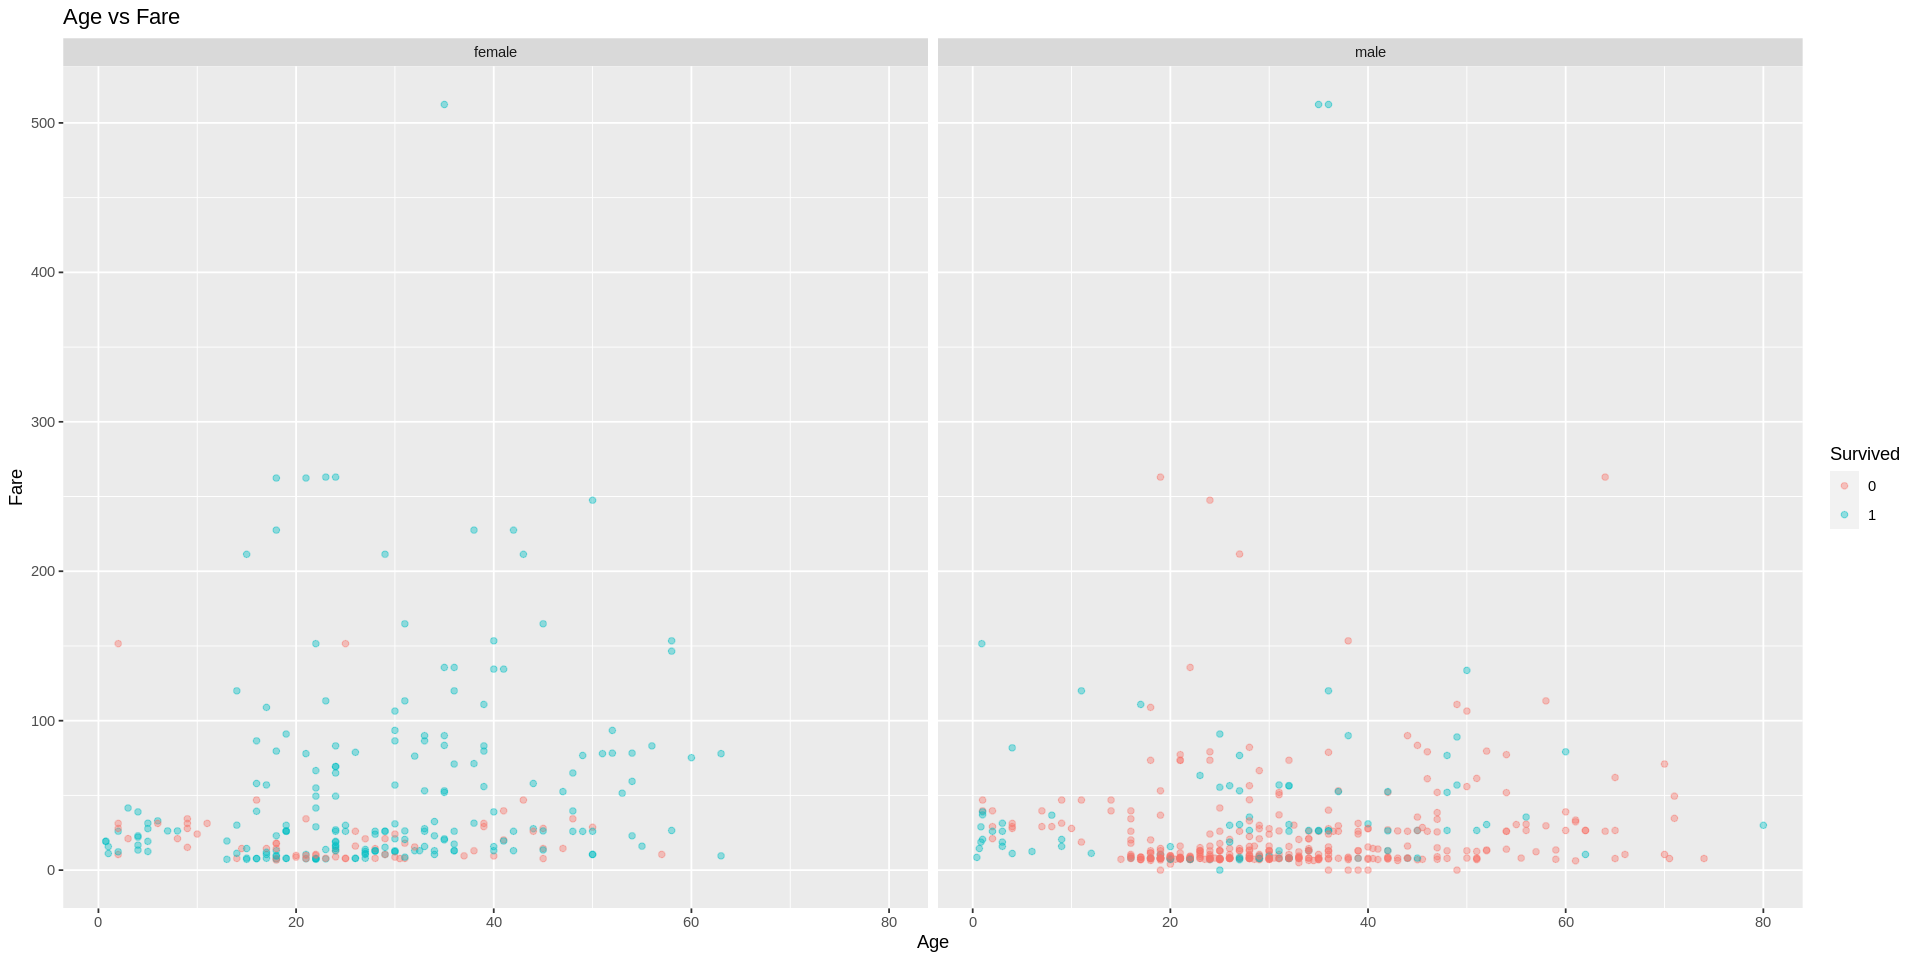

In [6]:
options(repr.plot.width = 16, repr.plot.height = 8) 
train %>% ggplot(aes(x = Age, y =  Fare, colour=Survived)) + 
           geom_point(alpha = 0.4) +
           xlab("Age") +
           ylab("Fare") +
           ggtitle("Age vs Fare") + facet_grid(. ~ Sex)

**Methods**: 

We used a knn classification to attempt to predict wether a passenger survived using Age and Fare as predictors, this has been done to confirm or reject the popular 'myth' of how the lower classes were the ones that were more vulnerable to perishing after the crash. Two datasets were used "train.csv" that has all columns described above and "test.csv" that contains all columns but 'Survived', hence the data from "train.csv" will be used to obtain a trained classifier to predict Survived for all the rows in "test.csv". Additionally, cross validation will be used to tune the classifier to the best 'k' value for number of neighbors, this means that part of the training  data will be used to evaluate the accuracy of the classifier in cross-validation, rather than to train it.

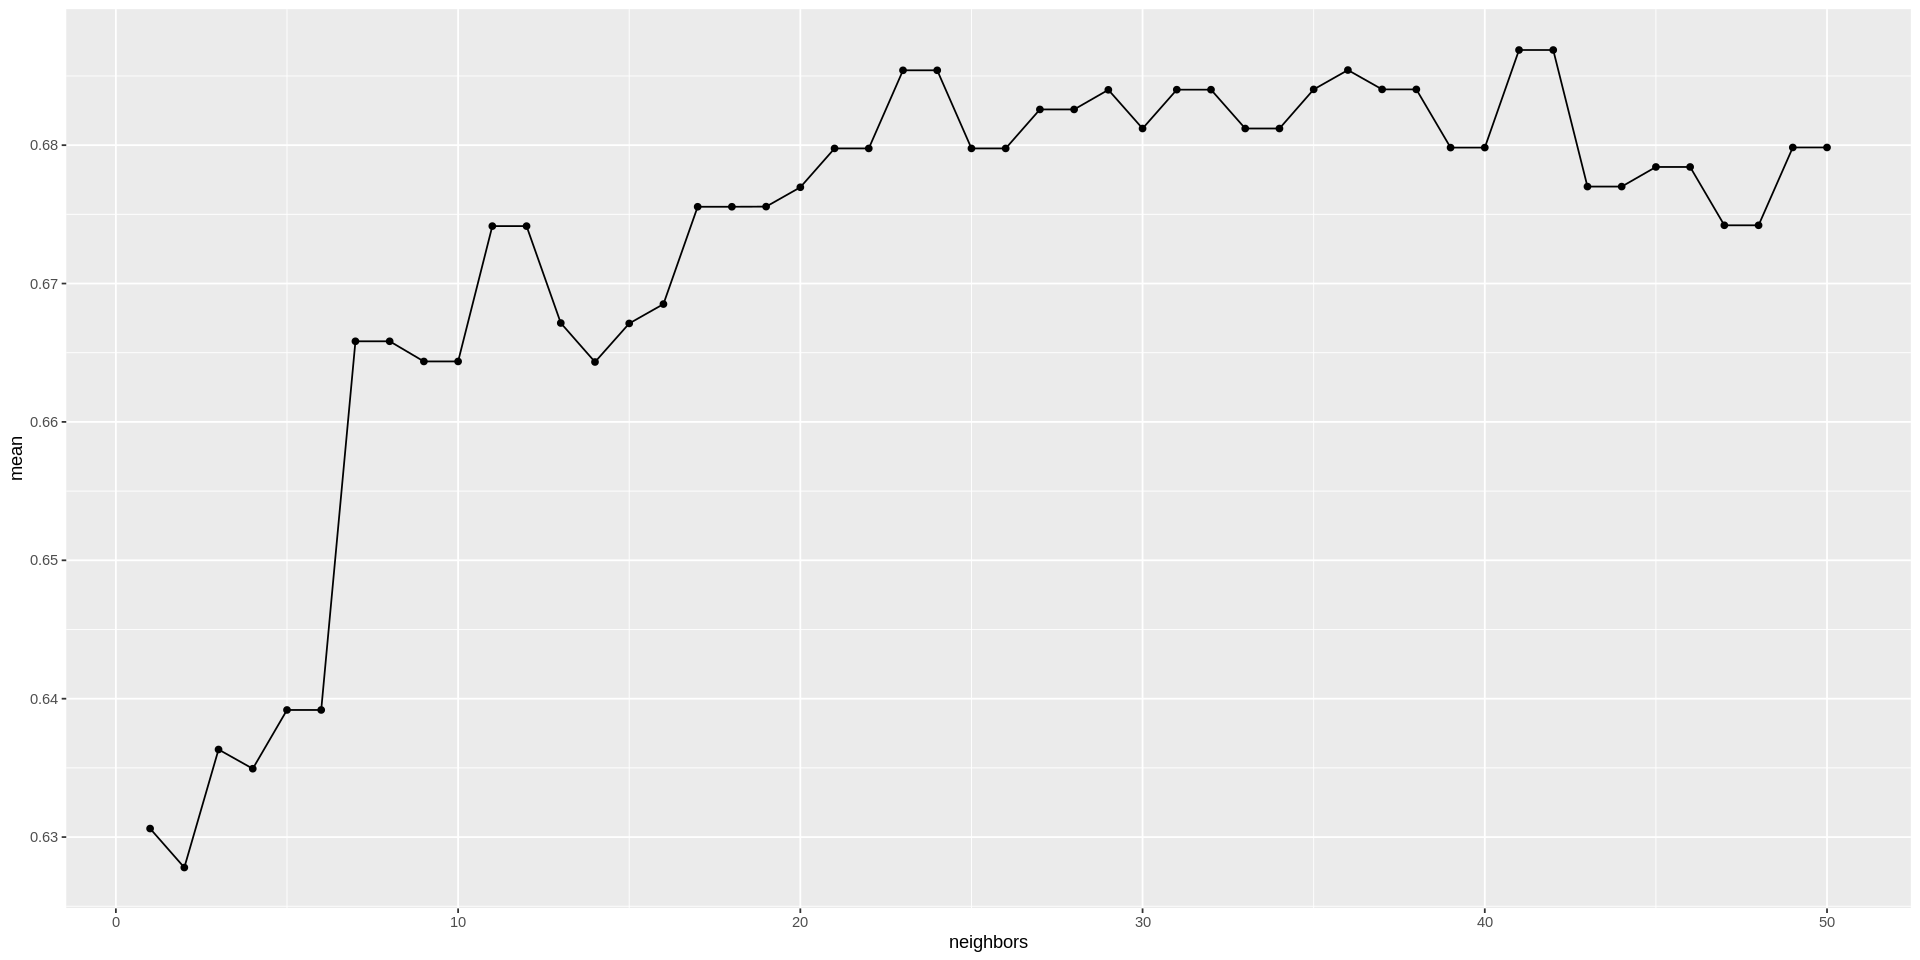

In [7]:
set.seed(2020) # DO NOT REMOVE

recipe <- recipe(Survived ~ Age + Fare , data = train) %>%
   step_scale(all_predictors()) %>%
    step_center(all_predictors())
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
the_vfold <- vfold_cv(train, v = 5, strata = Survived)

k_vals <- tibble(neighbors = seq(from = 1, to = 50))
results <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = the_vfold, grid = k_vals) %>%
      collect_metrics()
results %>% filter(.metric == "accuracy") %>%
                ggplot(aes(x=neighbors, y=mean))+ geom_point() + geom_line()


In [11]:
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 41) %>%
      set_engine("kknn") %>%
      set_mode("classification")
best_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(best_spec) %>%
        fit(data=train)
test <- read_csv("test.csv") %>%  drop_na(-Cabin)
predictions <- predict(best_fit,test) %>% bind_cols(test)

neighbors <- results %>% filter(.metric == "accuracy") %>%
    filter(mean == max(mean)) %>%
    head(1)
neighbors

Parsed with column specification:
cols(
  PassengerId = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Sex = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,accuracy,binary,0.6868747,5,0.0121589,Model41


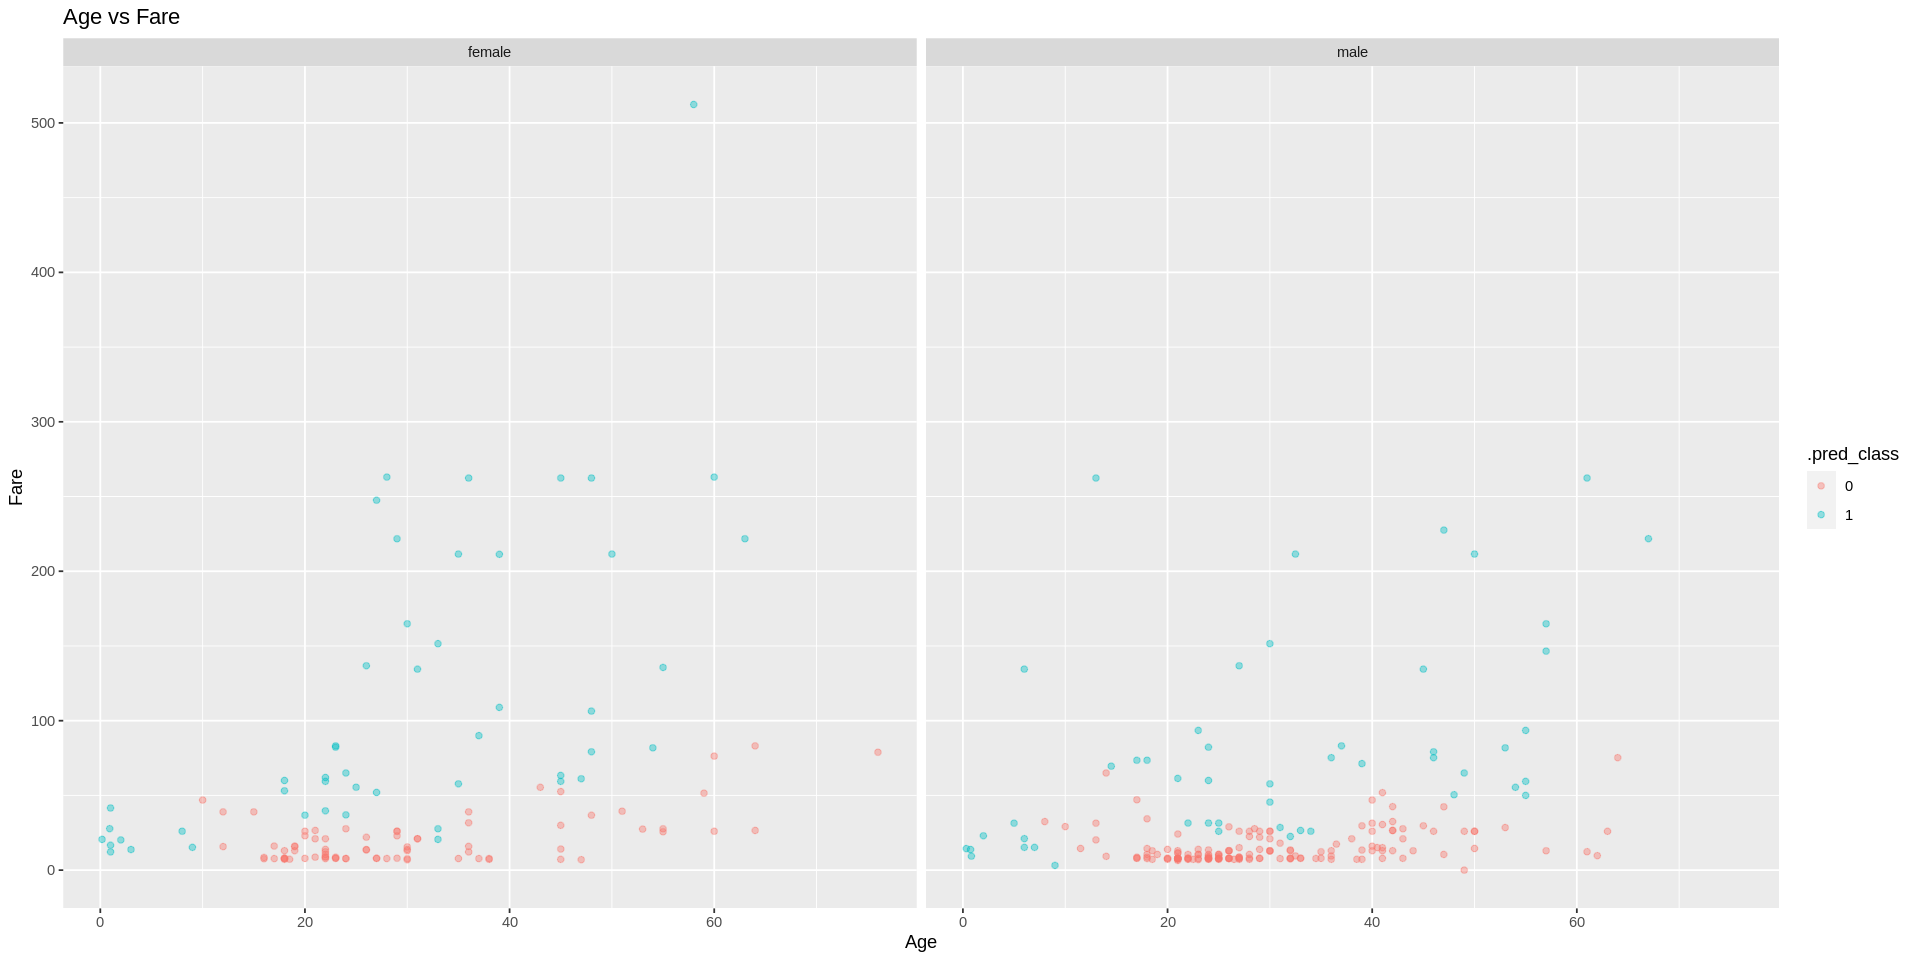

In [9]:
predictions %>% ggplot(aes(x = Age, y =  Fare, colour=.pred_class)) + 
           geom_point(alpha = 0.4) +
           xlab("Age") +
           ylab("Fare") +
           ggtitle("Age vs Fare") + facet_grid(. ~ Sex)

**3. Discussion**: 

summarize what you found



The results support the popular notion that the richer passengers(higher priced fares) were more likely to survive, the explanation may be that the higher the fare the better located the rooms that would allow for a faster evacuation; or more cynically the higher classes were prioritized during evacuation or even to spread the warning of the scale of the situation.

As we also expected, the younger people had higher odds of survival, being less vulnerable to the cold weather and more able to rapidly evacuate the boat after the crash.


discuss what impact could such findings have?

We investigated how fare and age affect one's survival based on personal factors like social status and when they were born. In further investigation, we could dive deep into the external factors that affect their survival, for instance, whether a passenger lived in a cabin when they were on the cruise. Cabins are cruise ship rooms that usually contain windows. Unlike people who didn't live in the Cabin, people living in Cabin may have higher chances to escape when the ship is sinking by breaking the windows. We could replace the variable “gender” with “cabin” to determine whether living in Cabin would be a choice for an emergency escape. Lastly, it also leads us to brainstorm the evacuation procedures to increase the survival chance in similar accidents.


**References:** 

Barratt, Nick (2009). Lost Voices From the Titanic: The Defi History. London: Random House. p. 93. ISBN 978-1-84809-151-1.

History.com Editors. “Titanic.” History.com, A&E Television Networks, 9 Nov. 2009, www.history.com/topics/early-20th-century-us/titanic#section_1.

Timbers,Tiffany. Campbell, Trevor and Lee, Melissa. Data Science: A First Introduction.\

Person. “Titanic Anniversary: Remembering the Third-Class Passengers.” ABC13 Houston, KTRK-TV, 11 Apr. 2021, abc13.com/titanic-anniversary-immigration-world-history/1874040/#:~:text=Approximately 1,317 passengers died when,their area of the Titanic